### Initial Set-Up

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


# Load dataset
df = pd.read_csv('data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Data Cleaning and Exploratory Data Analysis (EDA)

In this section, I have cleaned the dataset and explored key patterns related to diabetes prediction:

#### Data Cleaning
- Identified and replaced invalid zero values in clinical features (`Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`) with `NaN`.
- Imputed missing values using the **median** of each feature.
- Removed **duplicate records** to ensure data integrity.

#### Exploratory Data Analysis (EDA)
- Visualized **distribution histograms** for all numerical features to understand their spread.
- Used **boxplots** to detect and visualize potential outliers.
- Created a **correlation heatmap** to identify strong relationships between variables.
- Plotted the **class distribution of the target variable** (`Outcome`) to check for class imbalance.

#### Feature vs. Outcome Insights
- Visualized how key features like `Glucose`, `BMI`, and `Age` vary between diabetic and non-diabetic individuals using KDE and histograms.
- Found that individuals with higher glucose and BMI levels are more likely to be diabetic.

#### Feature Engineering
- Created new **categorical features**:
  - `AgeGroup`: Binned ages into categories (20s, 30s, 40s, etc.).
  - `BMI_Class`: Classified BMI into health categories (Underweight, Normal, Overweight, Obese).
- Visualized the distribution of diabetes outcome across age and BMI groups.


In [2]:
# Show count of zero values in columns where zero is invalid
invalid_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("Zero values in columns:")
print((df[invalid_cols] == 0).sum())

Zero values in columns:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [3]:
# Replace 0s with NaN for invalid columns
df[invalid_cols] = df[invalid_cols].replace(0, np.nan)

# Show % of missing values
print("\nMissing Value Percentage:")
print(df.isnull().mean() * 100)

# Impute with median
df[invalid_cols] = df[invalid_cols].fillna(df[invalid_cols].median())


Missing Value Percentage:
Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64


In [4]:
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Remove if any
df = df.drop_duplicates()


Duplicate rows: 0


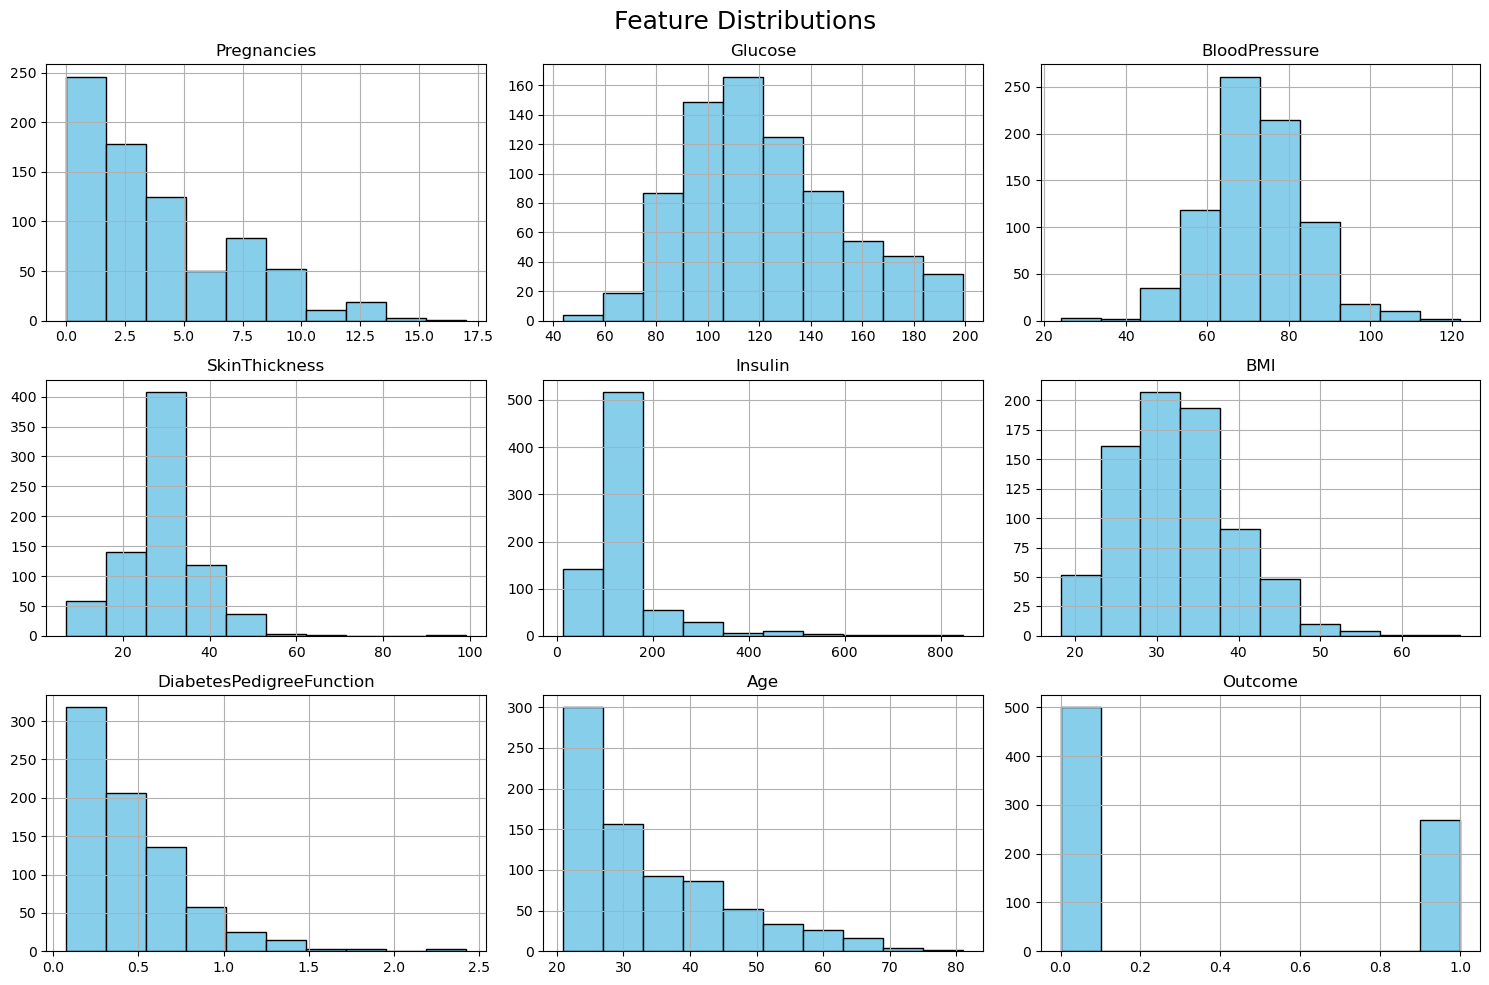

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms of all features
df.hist(figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout()
plt.show()

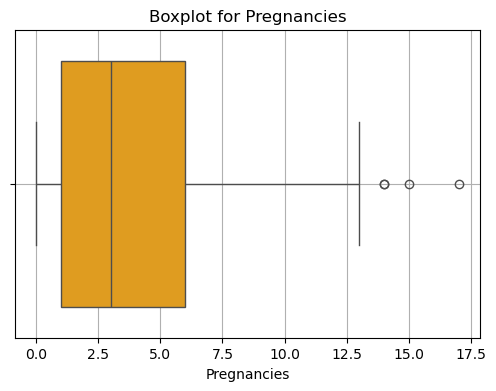

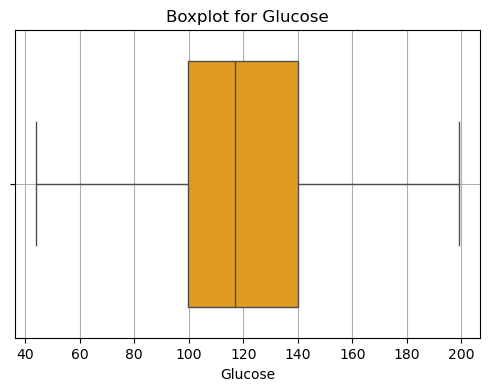

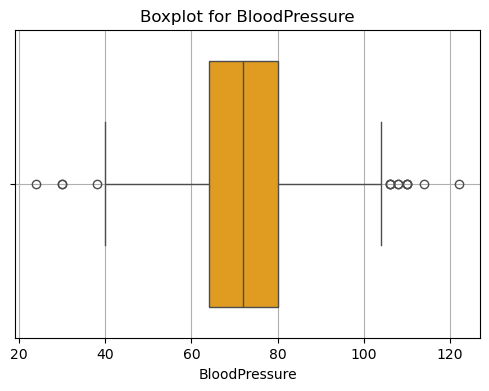

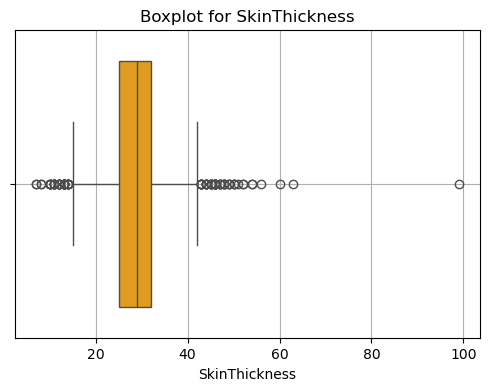

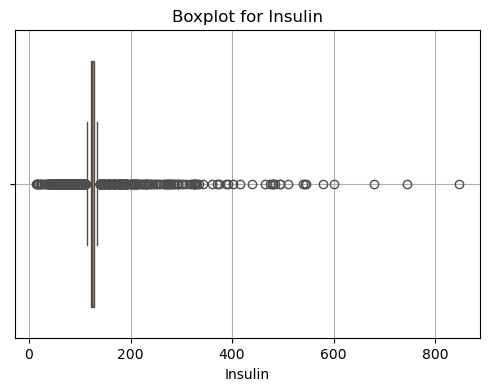

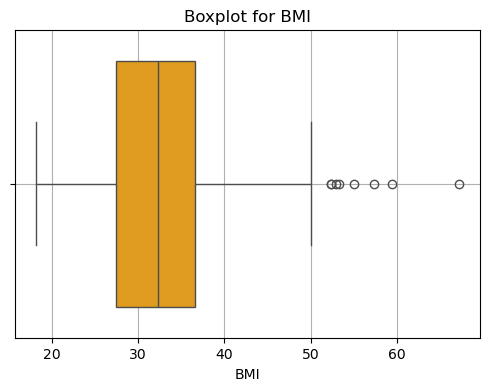

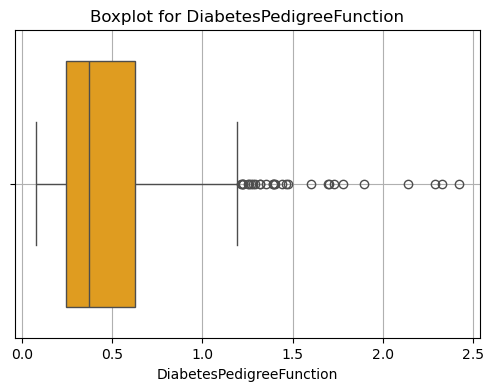

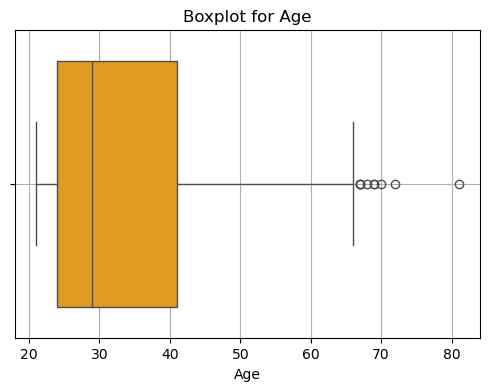

In [6]:
# Boxplots to detect outliers
for col in df.columns[:-1]:  # exclude 'Outcome'
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'Boxplot for {col}')
    plt.grid(True)
    plt.show()

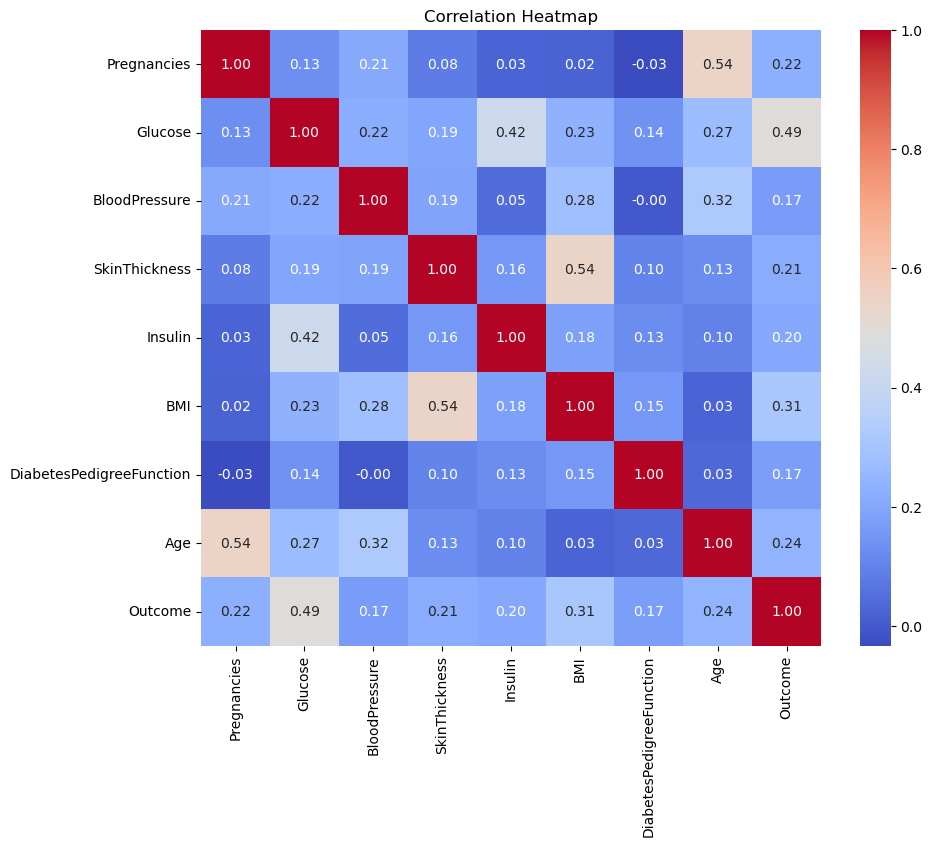

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

/var/folders/_j/p4d93xq163x1g4lz0lg2syf00000gn/T/ipykernel_966/78070281.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='Set2')


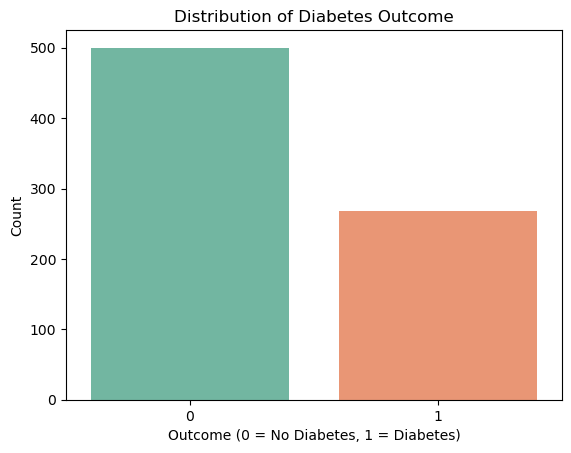

In [8]:
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
plt.ylabel('Count')
plt.show()

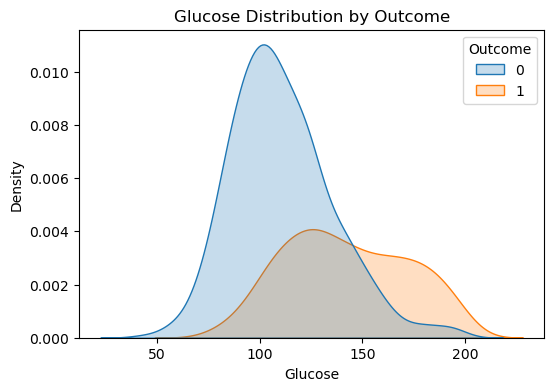

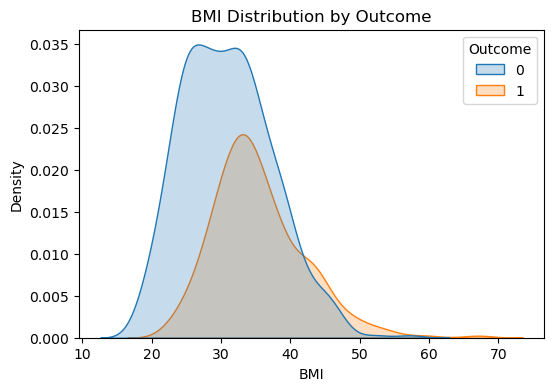

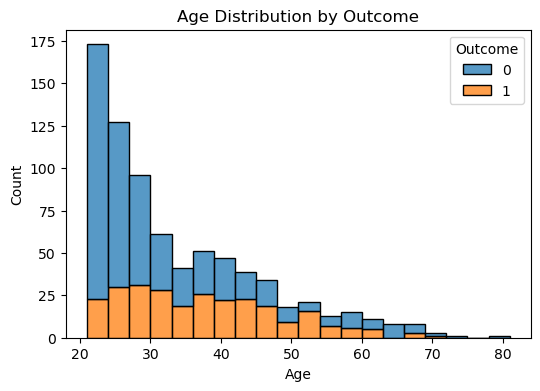

In [9]:
# Glucose vs Outcome
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df, x='Glucose', hue='Outcome', fill=True)
plt.title("Glucose Distribution by Outcome")
plt.show()

# BMI vs Outcome
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df, x='BMI', hue='Outcome', fill=True)
plt.title("BMI Distribution by Outcome")
plt.show()

# Age vs Outcome
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Age', hue='Outcome', multiple='stack', bins=20)
plt.title("Age Distribution by Outcome")
plt.show()

In [10]:
# Age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 80], labels=['20s', '30s', '40s', '50s', '60+'])

# BMI classification
df['BMI_Class'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],
                         labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Check new columns
print(df[['Age', 'AgeGroup', 'BMI', 'BMI_Class']].head())


   Age AgeGroup   BMI   BMI_Class
0   50      40s  33.6       Obese
1   31      30s  26.6  Overweight
2   32      30s  23.3      Normal
3   21      20s  28.1  Overweight
4   33      30s  43.1       Obese


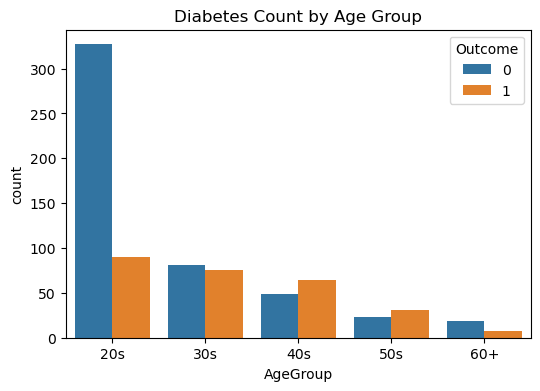

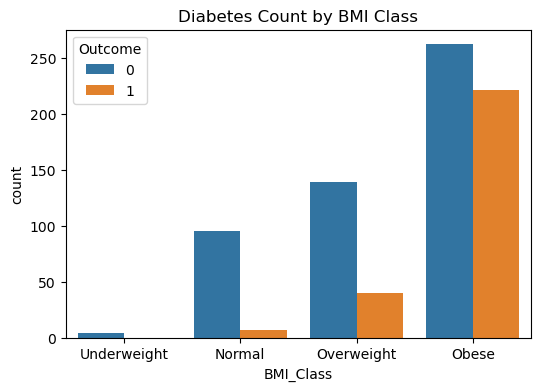

In [11]:
# Visualize new engineered features
plt.figure(figsize=(6,4))
sns.countplot(x='AgeGroup', hue='Outcome', data=df)
plt.title("Diabetes Count by Age Group")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='BMI_Class', hue='Outcome', data=df)
plt.title("Diabetes Count by BMI Class")
plt.show()


### Modeling

### Models Used

- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- Support Vector Machine (SVM)

### Evaluation Metrics

- **Accuracy:** Overall proportion of correct predictions.
- **Precision:** Correct positive predictions out of all positive predictions.
- **Recall:** Correct positive predictions out of all actual positives.
- **F1 Score:** Balance of precision and recall.
- **ROC AUC:** Ability of the model to discriminate between classes.

---

## Model Performance Summary

| Model                  | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|------------------------|----------|-----------|--------|----------|---------|
| Logistic Regression     | 0.753     | 0.667      | 0.618   | 0.642     | 0.821    |
| Decision Tree          | 0.708     | 0.583      | 0.636   | 0.609     | 0.692    |
| Random Forest          | 0.753     | 0.639      | 0.709   | 0.672     | 0.845    |
| Support Vector Machine  | 0.708     | 0.583      | 0.636   | 0.609     | 0.692    |

---

## Hyperparameter Tuning

- Performed Grid Search with cross-validation on Random Forest to optimize:
  - `n_estimators`: [50, 100, 150]
  - `max_depth`: [None, 5, 10]
  - `min_samples_split`: [2, 5, 10]
- Selected best parameters to improve model accuracy and robustness.

---

## Visualizations

- **ROC Curves:** Compare models' true positive and false positive rates.
- **Precision-Recall Curves:** Focus on model performance with imbalanced classes.
- **Feature Importance:** Random Forest identifies key predictors like `Glucose` and `BMI`.
- **Confusion Matrices:** Analyze types of classification errors.
- **Metric Comparison:** Bar charts for side-by-side evaluation of all models.




🔹 Logistic Regression Performance:
Accuracy: 0.7532
Precision: 0.6667
Recall: 0.6182
F1 Score: 0.6415
ROC AUC: 0.8228
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154


🔹 Decision Tree Performance:
Accuracy: 0.7208
Precision: 0.6071
Recall: 0.6182
F1 Score: 0.6126
ROC AUC: 0.6980
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154


🔹 Random Forest Performance:
Accuracy: 0.7338
Precision: 0.6250
R

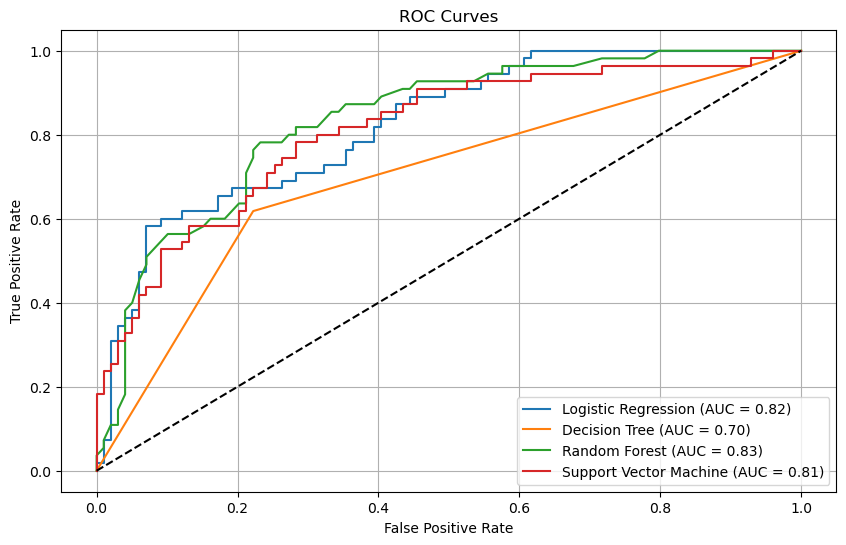

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Drop engineered categorical features for modeling (if present)
df_model = df.drop(columns=['AgeGroup', 'BMI_Class'])

# Split data into X and y
X = df_model.drop('Outcome', axis=1)
y = df_model['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

# Initialize results dictionary
results = {}

# Train, predict, and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # For ROC AUC
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Classification Report": classification_report(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "ROC Curve": roc_curve(y_test, y_proba)
    }

# Print summary metrics
for name, metrics in results.items():
    print(f"\n🔹 {name} Performance:")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print("Classification Report:\n", metrics['Classification Report'])

# Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, metrics in results.items():
    fpr, tpr, _ = metrics["ROC Curve"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {metrics['ROC AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [15]:
results_list = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    results_list.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1 Score": round(f1, 3),
        "ROC-AUC": round(roc_auc, 3) if roc_auc is not None else "N/A"
    })

results = pd.DataFrame(results_list)
results = results.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
print(results)


                   Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
0  Random Forest (Tuned)     0.753      0.639   0.709     0.672    0.845
1    Logistic Regression     0.753      0.667   0.618     0.642    0.821
2                    SVM     0.766      0.721   0.564     0.633    0.802
3          Decision Tree     0.708      0.583   0.636     0.609    0.692


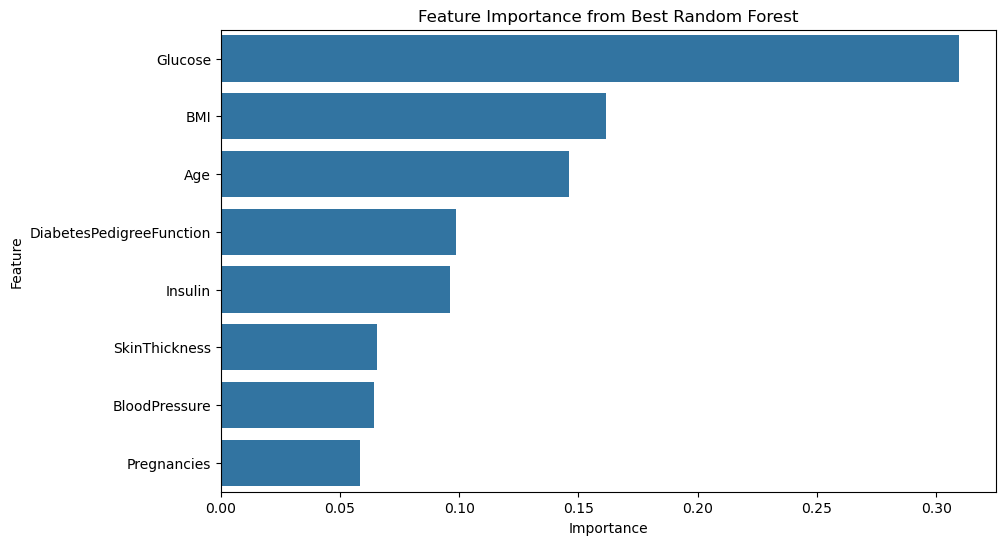

In [22]:
importances = best_rf.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importance from Best Random Forest")
plt.show()


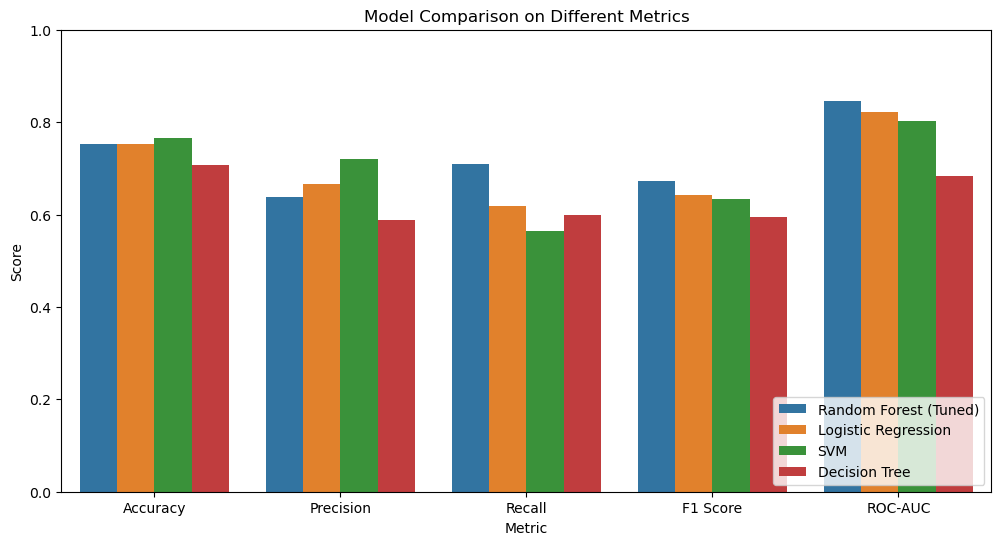

In [23]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

results_melted = results.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title("Model Comparison on Different Metrics")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()


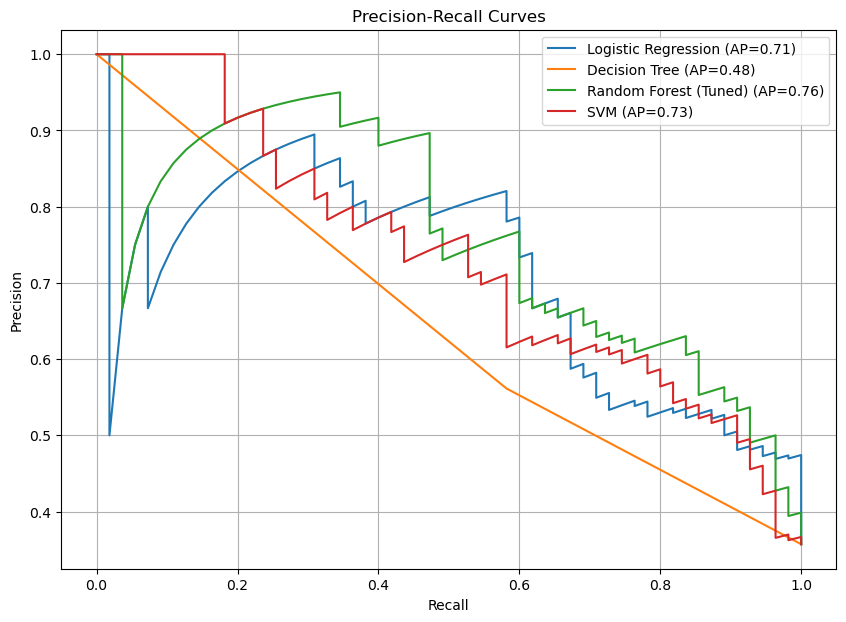

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()
